In [1]:
from Bio import SeqIO
from Bio.PDB import PDBParser, Select,PDBIO
import sys
import Bio.PDB as bpdb
import glob 
import os
import pandas as pd
import seaborn as sns
import math

sns.set_context("talk")
sns.set_theme(style="white")

In [2]:
# Not safe!
import warnings
warnings.filterwarnings('ignore')

# Given reference files and pdb, check if sequence is the same. 

In [9]:
def get_fasta(pdb_file):
    with open(pdb_file, 'r') as outfile:
        for record in SeqIO.parse(outfile, 'pdb-atom'):
             seq = record.seq
        return(str(seq))

def get_template(template_file):
    template = {}
    with open(template_file, 'r') as file:
        for line in file:
            template[line.split("_P_")[1].replace(">","").strip()] = line.split("_P_")[0].replace(">","").strip()
    inv_map = {v.replace("/", "_"): k for k, v in template.items()}
    return(inv_map)


def calculate_percent_identity(sequence1, sequence2):
    if(len(sequence1) != len(sequence2)):
        percent_identity = 0
    else: 
        aligned_sequences = []
        aligned_sequences.append(sequence1)
        aligned_sequences.append(sequence2)
        length = len(aligned_sequences[0])  # Assuming all sequences have the same length
        identical_count = sum(1 for i in range(length) if len(set(seq[i] for seq in aligned_sequences)) == 1)
        percent_identity = (identical_count / length) * 100
    return percent_identity

def get_summary_concordance(ref_fasta_files,pdb_folder, dataset = "", DB = "", colabfold = False, benchfam = False, uniprot = False):
    summary = pd.DataFrame()
    n = 1
    for ref_fasta in ref_fasta_files: 
        with open(ref_fasta, 'r') as file:
            fam = os.path.basename(ref_fasta).replace("-ref.fa", "")
            if uniprot: 
                fam = os.path.basename(ref_fasta).replace(".fa", "")
            if benchfam: 
                template_file = glob.glob( "/home/luisasantus/Desktop/crg_cluster/benchfam/"+fam+"/*.template_list")[0]
                template = get_template(template_file)
            for record in SeqIO.parse(file, "fasta"):
                seq_id = record.id
                pdb_name = seq_id+".pdb"
                if colabfold: 
                    pdb_file = glob.glob(os.path.join(pdb_folder, fam,"pdbs", pdb_name))
                elif benchfam: 
                    pdb_name = template[seq_id]+".pdb"
                    pdb_file = glob.glob(os.path.join(pdb_folder,fam, "PDB",pdb_name))
                else: 
                    pdb_file = glob.glob(os.path.join(pdb_folder, fam, pdb_name))
                    
                if(len(pdb_file) == 0 ): 
                    entry = pd.DataFrame([{ "family": fam, "seq_id":seq_id, "same_seq": "not found", "found": False}])
                    summary = pd.concat([summary,entry], ignore_index=True)
                else: 
                    same_seq = get_fasta(pdb_file[0]) == str(record.seq)
                    sim_seq = calculate_percent_identity(get_fasta(pdb_file[0]),str(record.seq) )
                    entry = pd.DataFrame([{ "family": fam, "seq_id":seq_id, "same_seq": same_seq, "sim_seq": sim_seq, "found": True}])
                    summary = pd.concat([summary,entry], ignore_index=True)
            print(n)
            n += 1
    summary["dataset"] = dataset
    summary["DB"] = DB
    return(summary)


def clean_summary(summary, threshold_similarity = 100):
    
    datasets = summary[["family", "dataset", "DB"]].drop_duplicates()
    if len(summary[summary.found == True][["family", "same_seq"]][summary.same_seq == False]) == 0 : 
        not_correct_df = summary[["family", "dataset"]]
        not_correct_df = not_correct_df.rename(columns = {"dataset":"not_correct_n"})
        not_correct_df["not_correct_n"] = 0 
    else: 
        not_correct_df = summary[summary.found == True][["family", "same_seq"]][summary.same_seq == False].groupby("family").count().reset_index().rename(columns = {"same_seq":"not_correct_n"})
    
    # How many sequences have a PDB assigned? 
    tot_summary = summary[["family", "seq_id"]].groupby(["family"]).count().reset_index().rename(columns = {"seq_id":"n_seq" })
    found_summary = summary[summary.found == True][["family", "seq_id"]].groupby(["family"]).count().reset_index().rename(columns = {"seq_id":"found_seq" })
    summary_str = found_summary.merge(tot_summary, on ="family" )
    summary_str["found_all"] = summary_str.found_seq == summary_str.n_seq


    # From the sequences that were found, are they all clean? 
    # Check if all the sequences identified were correct 
    summary_found_correct = summary[summary.found == True][["family", "same_seq"]].drop_duplicates()
    summary_found_correct["correct_all"] = summary_found_correct.groupby('family')['same_seq'].transform(lambda x: x.nunique() == 1)
    summary_found_correct = summary_found_correct.drop("same_seq", axis = 1).reset_index().drop("index", axis = 1)

    # Check if all the sequences identified were correct 
    summary_found_sim = summary.groupby('family')['sim_seq'].apply(lambda x: all(x > threshold_similarity)).reset_index()
    
    # Merge the infos together 
    summary_str = summary_str.merge(summary_found_correct, on ="family" )
    summary_str = summary_str.merge(datasets, on ="family" )
    summary_str = summary_str.merge(not_correct_df, on ="family" )
    summary_str = summary_str.merge(summary_found_sim, on ="family" )
    summary_str = summary_str.drop_duplicates()
    return(summary_str)




# HOMFAM

In [4]:
# Homfam 
homfam_refs = glob.glob("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/refs/*.fa")

In [201]:
# PDB FETCH 
#homfam_pdb_folder = "/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/PDB/id_1.0_cov_1.0/"
#homfam_pdb_fetch = get_summary_concordance(homfam_refs, homfam_pdb_folder, "homfam", "PDB-fetch")
#homfam_pdb_fetch_clean = clean_summary(homfam_pdb_fetch)
#homfam_pdb_fetch_clean.to_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/structure_fetch_summary_homfam_PDB_fetch.csv", index = False) 

In [200]:
# AF2_pred 
#homfam_af2_folder = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/af2_structures/colabfold_header/"
#homfam_af2 = get_summary_concordance(homfam_refs, homfam_af2_folder, "homfam", "AF2_PRED", colabfold = True)
#homfam_af2_clean = clean_summary(homfam_af2)
#homfam_af2_clean.to_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/structure_fetch_summary_homfam_af2.csv", index = False) 

In [8]:
# UNIPROT FETCH 
homfam_uniprot_folder = "/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/"
homfam_uniprot_fetch = get_summary_concordance(homfam_refs, homfam_uniprot_folder, "homfam", "UNIPROT-fetch", uniprot = True)
homfam_uniprot_fetch_clean = clean_summary(homfam_uniprot_fetch, 95)
#homfam_uniprot_fetch_clean.to_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/structure_fetch_summary_homfam_uNIPROT_fetch.csv", index = False)
homfam_uniprot_fetch_clean

['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/DMRL_synthase-ref/1rvva.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/DMRL_synthase-ref/1c2ya.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/DMRL_synthase-ref/1ejba.pdb']
[]
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/DMRL_synthase-ref/1di0a.pdb']
1
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/oxidored_q6-ref/1frfs.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/oxidored_q6-ref/2frva.pdb']
[]
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB

['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/p450-ref/1cpt.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/p450-ref/1n40a.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/p450-ref/1qmqa.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/p450-ref/1e9xa.pdb']
12
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/aldosered-ref/1ah4.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/aldosered-ref/1ads.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/aldosered-ref/1frb.pdb']
['/hom

['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ldh-ref/1llc.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ldh-ref/1llda.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ldh-ref/9ldba.pdb']
[]
[]
[]
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ldh-ref/1hlpa.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ldh-ref/4mdha.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ldh-ref/1bdma.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ldh-ref/1ceqa.pdb']
['/home/luisasantus

['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/glob-ref/1a9we.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/glob-ref/1hbra.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/glob-ref/1a6m.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/glob-ref/1cg5a.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/glob-ref/1cg5b.pdb']
32
[]
[]
[]
[]
[]
33
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/flav-ref/1flv.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/flav-ref/1ofv.pdb']
['

['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/phoslip-ref/1cl5a.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/phoslip-ref/1clpa.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/phoslip-ref/1goda.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/phoslip-ref/1ppa.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/phoslip-ref/1bbc.pdb']
65
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/phc-ref/1phnb.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/phc-ref/1cpcb.pdb']
['/hom

['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/egf-ref/1dan2.pdb']
[]
83
[]
[]
[]
[]
[]
[]
[]
84
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
85
[]
[]
[]
[]
[]
[]
86
[]
[]
[]
[]
[]
87
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ghf13-ref/6taa.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ghf13-ref/2aaa.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ghf13-ref/1cgt.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ghf13-ref/1cdg.pdb']
['/home/luisasantus/Desktop/crg_cluster/data/structures_collections/homfam_ref/DB/structures/UniProtKB/id_0.95_cov_1.0/ghf13-ref/1cyg.pdb']
[]
['/home/luisasantus/Desktop/crg_cluster/data/structures_

,family,found_seq,n_seq,found_all,correct_all,dataset,DB,not_correct_n,sim_seq
0,Ald_Xan_dh_2-ref,5,6,False,False,homfam,UNIPROT-fetch,3,False
2,DMRL_synthase-ref,4,5,False,False,homfam,UNIPROT-fetch,2,False
4,GEL-ref,4,5,False,False,homfam,UNIPROT-fetch,1,False
6,Stap_Strp_toxin-ref,4,6,False,False,homfam,UNIPROT-fetch,2,False
8,TNF-ref,5,5,True,False,homfam,UNIPROT-fetch,1,True
10,ace-ref,4,6,False,False,homfam,UNIPROT-fetch,2,False
12,adh-ref,5,5,True,False,homfam,UNIPROT-fetch,1,True
14,aldosered-ref,6,7,False,False,homfam,UNIPROT-fetch,1,False
16,annexin-ref,4,6,False,False,homfam,UNIPROT-fetch,1,False
18,blm-ref,8,8,True,False,homfam,UNIPROT-fetch,2,True


In [16]:
",".join(list(homfam_uniprot_fetch_clean[homfam_uniprot_fetch_clean.sim_seq == True].family.replace("-ref", "")))

'TNF-ref,adh-ref,blm-ref,flav-ref,hpr-ref,mmp-ref,msb-ref,profilin-ref,ricin-ref,slectin-ref'

In [20]:
homfam_pdb_fetch_clean = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/structure_fetch_summary_homfam_PDB_fetch.csv")
homfam_af2_clean  = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/structure_fetch_summary_homfam_af2.csv")
homfam_uniprot_fetch_clean = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/structure_fetch_summary_homfam_uNIPROT_fetch.csv")
homfam = pd.concat([homfam_af2_clean, homfam_pdb_fetch_clean, homfam_uniprot_fetch_clean])

In [205]:
homfam

,family,found_seq,n_seq,found_all,correct_all,dataset,DB
0,Acetyltransf,6,6,True,True,homfam,AF2_PRED
1,Ald_Xan_dh_2,6,6,True,True,homfam,AF2_PRED
2,ChtBD,5,5,True,True,homfam,AF2_PRED
3,DEATH,7,7,True,True,homfam,AF2_PRED
4,DMRL_synthase,5,5,True,True,homfam,AF2_PRED
...,...,...,...,...,...,...,...
88,tms,5,5,True,True,homfam,PDB-fetch
89,toxin,19,20,False,True,homfam,PDB-fetch
90,trfl,6,7,False,True,homfam,PDB-fetch
91,uce,12,13,False,True,homfam,PDB-fetch


## Homfam checks

In [21]:
homfam_af2_clean = homfam_af2_clean

In [22]:
# Check 1: 

# AF2_PRED ALWAYS HAS ALL THE STRUCTURES AND ARE ALL CORRECT
print("Found all the structures")
print(homfam_af2_clean["found_all"].value_counts())
print("-----------------------------------------")

print("All the structures are correct")
print(homfam_af2_clean["correct_all"].value_counts())
print("----------------------------------------")

print("Wrong families")
homfam_af2_clean[homfam_af2_clean.correct_all == False]

Found all the structures
True    94
Name: found_all, dtype: int64
-----------------------------------------
All the structures are correct
True     92
False     2
Name: correct_all, dtype: int64
----------------------------------------
Wrong families


,family,found_seq,n_seq,found_all,correct_all,dataset,DB
27,bowman,5,5,True,False,homfam,AF2_PRED
34,egf,12,12,True,False,homfam,AF2_PRED


In [19]:
# PDB FETCH HAS NOT ALL THE STRUCTURES, BUT NOW THE ONES FOUND ARE CORRECT
print("Found all the structures")
print(homfam_pdb_fetch_clean["found_all"].value_counts())
print("-----------------------------------------")


print("All the structures are correct")
print(homfam_pdb_fetch_clean["correct_all"].value_counts())
print("----------------------------------------")


print("Wrong families")
homfam_pdb_fetch_clean[homfam_pdb_fetch_clean.correct_all == False]


Found all the structures


NameError: name 'homfam_pdb_fetch_clean' is not defined

In [242]:
# FAMILIES I CAN USE FOR THE PDB BENCHMARK 
clean_and_complete_pdb_fams = homfam_pdb_fetch_clean[(homfam_pdb_fetch_clean.found_all == True) & (homfam_pdb_fetch_clean.correct_all == True)]
','.join(list(clean_and_complete_pdb_fams.family))

'Acetyltransf,DEATH,GEL,HMG_box,LIM,PDZ,annexin,az,biotin_lipoyl,cyt3,flav,gluts,hip,hla,hom,hpr,icd,il8,int,phoslip,profilin,ricin,rvp,scorptoxin,seatoxin,slectin,sodfe,tim,tms'

# BENCHFAM 

In [13]:
benchfam_refs = glob.glob("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/benchfam/refs/*fa")

In [14]:
# PDB REAL 
benchfam_pdb_folder = "/home/luisasantus/Desktop/crg_cluster/benchfam/"
benchfam_pdb_fetch = get_summary_concordance(benchfam_refs, benchfam_pdb_folder, "benchfam", "PDB-real", benchfam = True)
benchfam_pdb_fetch.to_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/benchfam_sim_summary.csv", index = False)

benchfam_pdb_fetch_clean = clean_summary(benchfam_pdb_fetch,95)
benchfam_pdb_fetch_clean.to_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/structure_fetch_summary_benchfam_pdbreal_95.csv", index = False)
benchfam_pdb_fetch_clean

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,family,found_seq,n_seq,found_all,correct_all,dataset,DB,not_correct_n,sim_seq
0,PF00004,16,16,True,False,benchfam,PDB-real,8,False
2,PF00005,66,66,True,False,benchfam,PDB-real,18,False
4,PF00006,21,21,True,False,benchfam,PDB-real,2,False
6,PF00008,16,16,True,False,benchfam,PDB-real,2,False
8,PF00010,12,12,True,False,benchfam,PDB-real,3,True
...,...,...,...,...,...,...,...,...,...
1199,PF14497,10,10,True,False,benchfam,PDB-real,4,False
1201,PF14520,10,10,True,False,benchfam,PDB-real,2,False
1203,PF14833,13,13,True,False,benchfam,PDB-real,4,False
1205,PF16168,10,10,True,False,benchfam,PDB-real,1,False


In [27]:
",".join(list(benchfam_pdb_fetch_clean[benchfam_pdb_fetch_clean.sim_seq == True].family))

'PF00010,PF00018,PF00051,PF00053,PF00057,PF00062,PF00084,PF00134,PF00178,PF00185,PF00190,PF00191,PF00205,PF00233,PF00249,PF00251,PF00255,PF00258,PF00295,PF00314,PF00334,PF00341,PF00355,PF00405,PF00408,PF00432,PF00462,PF00484,PF00541,PF00620,PF00626,PF00652,PF00653,PF00677,PF00691,PF00722,PF00730,PF00731,PF00881,PF00884,PF00890,PF00961,PF00969,PF01011,PF01023,PF01030,PF01077,PF01152,PF01239,PF01263,PF01488,PF01547,PF01565,PF01568,PF01571,PF01670,PF01842,PF01909,PF02310,PF02321,PF02332,PF02502,PF02558,PF02749,PF02770,PF02776,PF02777,PF02803,PF02807,PF02852,PF02874,PF02881,PF03143,PF04777,PF07687,PF07885,PF08031,PF08544,PF08545,PF12799,PF13412,PF13531,PF13855,PF13857'

<AxesSubplot:xlabel='sim_seq', ylabel='Count'>

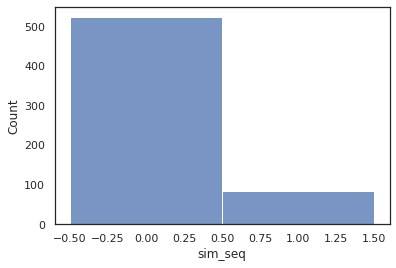

In [24]:
sns.histplot(data = benchfam_pdb_fetch_clean, x = "sim_seq", bins=2, discrete=True)

In [1]:
benchfam_pdb_fetch_clean = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/structure_fetch_summary_benchfam_pdbreal.csv")

NameError: name 'pd' is not defined

In [34]:
fams = glob.glob("/home/luisasantus/Desktop/crg_cluster/data/structures_collections/benchfam_ref/mmseqs/UniProtKB/*")

",".join(list([x.split("/")[-1].replace("-ref", "") for x in fams]))

'PF00112,PF00036,PF00035,PF13354,PF07992,PF08031,PF00305,PF14200,PF00576,PF03129,PF13508,PF01053,PF01487,PF01037,PF01661,PF02797,PF01011,PF00398,PF06628,PF00160,PF01187,PF00709,PF00782,PF00462,PF00059,PF00167,PF02879,PF00579,PF02525,PF01047,PF02875,PF05544,PF01850,PF05191,PF00191,PF00855,PF01670,PF14604,PF14497,PF02880,PF00412,PF00754,PF01123,PF02627,PF00961,PF01259,PF00871,PF02629,PF00067,PF00749,PF13344,PF00581,PF00326,PF00069,PF00331,PF01451,PF02894,PF13424,PF01510,PF03099,PF07676,PF00856,PF00405,PF04616,PF10415,PF02866,PF13412,PF03009,PF00107,PF00134,PF02800,PF00062,PF00571,PF00085,PF00185,PF01315,PF00704,PF01472,PF12799,PF02779,PF01494,PF01588,PF01565,PF08241,PF16168,PF00596,PF00544,PF03725,PF00392,PF00068,PF13410,PF01041,PF00080,PF00386,PF02776,PF01568,PF07715,PF13414,PF01327,PF00890,PF00456,PF00328,PF00179,PF00840,PF02221,PF00452,PF00491,PF00531,PF01168,PF00756,PF13545,PF00557,PF13857,PF01678,PF00285,PF00696,PF04055,PF01212,PF00763,PF00731,PF08545,PF00194,PF00686,PF00089,PF02793

In [35]:
len(list([x.split("/")[-1].replace("-ref", "") for x in fams]))

600

In [83]:
benchfam_pdb_fetch_clean[benchfam_pdb_fetch_clean.not_correct_n == 0 ]

,family,found_seq,n_seq,found_all,correct_all,dataset,DB,not_correct_n


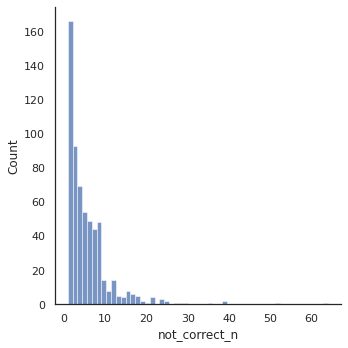

In [82]:
sns.displot(data = benchfam_pdb_fetch_clean, x = "not_correct_n")

In [ ]:
# PDB REAL 
benchfam_pdbfetch_folder = "/home/luisasantus/Desktop/crg_cluster/benchfam/"
benchfam_pdbfetch = get_summary_concordance(benchfam_refs, benchfam_pdb_folder, "benchfam", "PDB-real", benchfam = True)
benchfam_pdb_fetch_clean = clean_summary(benchfam_pdb_fetch)
#benchfam_pdb_fetch_clean.to_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/structure_fetch_summary_benchfam_pdbreal.csv", index = False)
benchfam_pdb_fetch_clean

In [52]:
file= "/home/luisasantus/Desktop/test_ungapped/fasta.fa"



In [53]:
sequences = []
for record in SeqIO.parse(file, "fasta"):
     aligned_sequences.append(str(record.seq))

In [54]:
calculate_percent_identity(aligned_sequences)

49.6